In [1]:
import numpy as np 
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
# Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
import time
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import string
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_all = pd.read_csv('/Users/zhangyuchen/Desktop/Data Science for Business/Team Project/hotel_bookings.csv')

In [3]:
df_all

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [4]:
df_cy=df_all[40061:]
df_cy=df_cy.reset_index().drop(['index'],axis=1)

In [5]:
df_cy.isnull().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                              24
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              8131
company                           75640


In [6]:
#Drop hotel column and columns contain too much Nan value
#drop rows contain Nan (children)
df_cy=df_cy.drop(['hotel','agent','company','country','reservation_status','reservation_status_date'],axis=1)
df_cy = df_cy.dropna()

In [7]:
#Turn category value to dummy 
for j in ['meal', 'market_segment', 'distribution_channel', 'deposit_type', 
          'customer_type', 'reserved_room_type', 'assigned_room_type']:
    dummy=pd.get_dummies(df_cy[j],drop_first=False,prefix=j)
    df_cy=pd.concat([df_cy,dummy],axis=1)
    df_cy=df_cy.drop([j],axis=1)

In [8]:
#Change month string to int
df_cy['arrival_date_month'] = pd.to_datetime(df_cy['arrival_date_month'], format='%B').dt.month

In [9]:
#add a column to see if reserved room is the same type as assigned room
c=[]
for j in range(len(df_cy)):
    if df_all['reserved_room_type'][j]!=df_all['assigned_room_type'][j]:
        c.append(1)
    else:
        c.append(0)
df_cy['dif_reserved_assigned']=c

In [10]:
df_X=df_cy.drop(['is_canceled'],axis=1)
df_y=df_cy['is_canceled']

# Lasso

In [11]:
#Lasso feature selection
from sklearn.linear_model import LassoCV
model = LassoCV(cv=10)
model.fit(df_X, df_y)

# 计算每个特征的系数和p值
coef = pd.Series(model.coef_, index = list(df_cy.columns)[1::])
coef_with_pvalues = pd.DataFrame({'coef': coef})

In [12]:
#best alpha
model.alpha_

0.016922062117681123

In [13]:
X_c=[]
for j in list(coef.index):
    if coef[j]!=0:
        X_c.append(j)
        print(j,coef[j])

lead_time 0.0007634066971554559
arrival_date_week_number -0.000670473149355284
stays_in_week_nights 0.01142195439680044
previous_cancellations 0.008467498753971792
booking_changes -0.02930855763900751
days_in_waiting_list -0.0002246313469209597
adr 0.0006459785817046861
total_of_special_requests -0.10283641546137236
market_segment_Online TA 0.05719915171923063
deposit_type_No Deposit -0.36211919977975027
deposit_type_Non Refund 0.0690774804865463
customer_type_Transient-Party -0.032170179332805346
dif_reserved_assigned 0.08270298987448943


In [14]:
X_after=df_X[X_c]

In [15]:
X_after

,lead_time,arrival_date_week_number,stays_in_week_nights,previous_cancellations,booking_changes,days_in_waiting_list,adr,total_of_special_requests,market_segment_Online TA,deposit_type_No Deposit,deposit_type_Non Refund,customer_type_Transient-Party,dif_reserved_assigned
0,88,27,4,0,0,0,76.50,1,1,1,0,0,0
1,65,27,4,0,0,0,68.00,1,1,1,0,0,0
2,92,27,4,0,0,0,76.50,2,1,1,0,0,1
3,100,27,2,0,0,0,76.50,1,1,1,0,0,0
4,79,27,3,0,0,0,76.50,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79324,23,35,5,0,0,0,96.14,0,0,1,0,0,0
79325,102,35,5,0,0,0,225.43,2,1,1,0,0,0
79326,34,35,5,0,0,0,157.71,4,1,1,0,0,0
79327,109,35,5,0,0,0,104.40,0,1,1,0,0,1


# Prediction after Lasso

In [16]:
y_train,y_test=train_test_split(df_y, test_size=0.3, random_state=29)

In [17]:
X_train, X_test = train_test_split(X_after, test_size=0.3, random_state=29)

In [18]:
#Logistic Regression
T1 = time.time()
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
T2 = time.time()
log_ac = accuracy_score(y_test,logreg.predict(X_test))
log_pre=logreg.predict_proba(X_test)
time_log=(T2 - T1)*1000
# print("accuracy:%f"%log_ac)
# log_cv = cross_val_score(logreg, X_train, y_train, cv=10)
# log_cv_score = log_cv.mean()

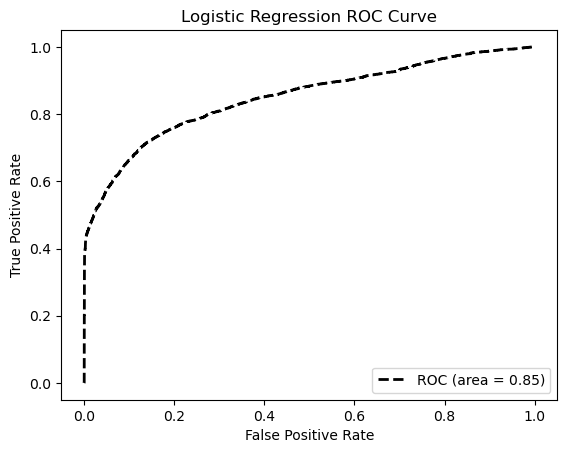

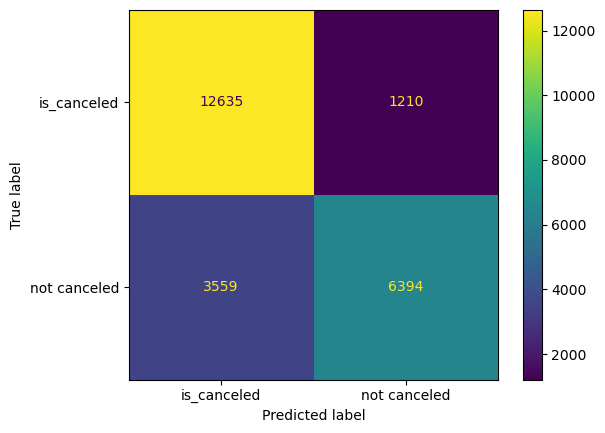

In [19]:
fpr, tpr, thersholds = roc_curve(y_test, list(log_pre[:,1]))
# for i, value in enumerate(thersholds):
#     print("%f %f %f" % (fpr[i], tpr[i], value))
 
log_auc = roc_auc_score(y_test,list(log_pre[:,1]))
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(log_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
confusion_mat=confusion_matrix(y_test, logreg.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['is_canceled','not canceled'])
disp.plot(
    include_values=True,            
    cmap="viridis",                 
    ax=None,                        
    xticks_rotation="horizontal",   
    values_format="d"               
)
plt.show()
plt.show()

In [20]:
#KNN
T1 = time.time()
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
T2 = time.time()
knn_ac = accuracy_score(y_test,knn.predict(X_test))
knn_pre=knn.predict_proba(X_test)
time_knn=(T2 - T1)*1000

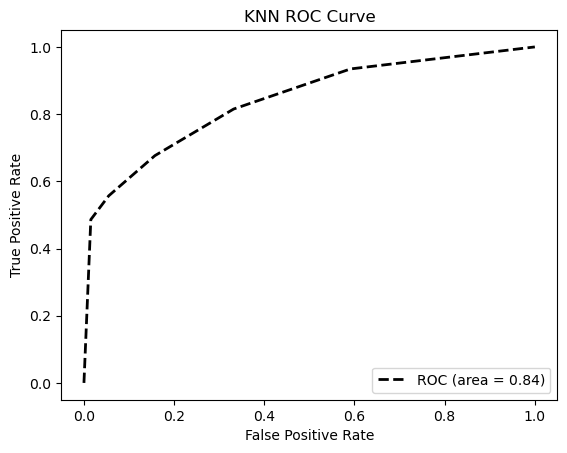

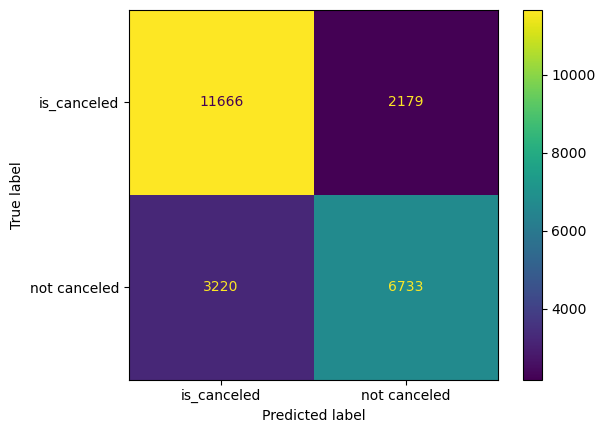

In [21]:
fpr, tpr, thersholds = roc_curve(y_test, list(knn_pre[:,1]))
# for i, value in enumerate(thersholds):
#     print("%f %f %f" % (fpr[i], tpr[i], value))
 
knn_auc = roc_auc_score(y_test,list(knn_pre[:,1]))
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(knn_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")
confusion_mat=confusion_matrix(y_test, knn.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['is_canceled','not canceled'])
disp.plot(
    include_values=True,            
    cmap="viridis",                 
    ax=None,                        
    xticks_rotation="horizontal",   
    values_format="d"               
)
plt.show()
plt.show()

In [22]:
#Decision Tree
T1 = time.time()
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, y_train) 
T2 = time.time()
dt_pre=decision_tree.predict_proba(X_test)
dt_ac = accuracy_score(y_test,decision_tree.predict(X_test))
time_dt=(T2 - T1)*1000
# print("accuracy:%f"%dt_ac)
# dt_cv = cross_val_score(decision_tree, X_train, y_train, cv=10)
# dt_cv_score = dt_cv.mean()

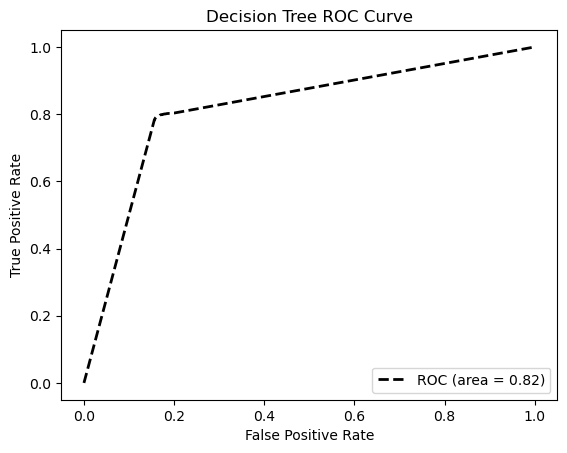

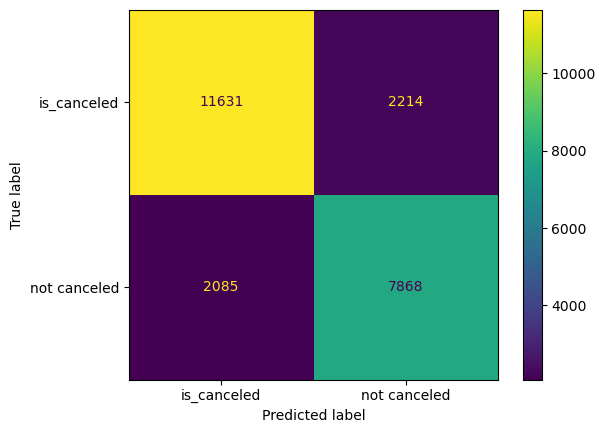

In [23]:
fpr, tpr, thersholds = roc_curve(y_test, list(dt_pre[:,1]))
# for i, value in enumerate(thersholds):
#     print("%f %f %f" % (fpr[i], tpr[i], value))
 
dt_auc = roc_auc_score(y_test,list(dt_pre[:,1]))
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(dt_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('Decision Tree ROC Curve')
plt.legend(loc="lower right")
confusion_mat=confusion_matrix(y_test, decision_tree.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['is_canceled','not canceled'])
disp.plot(
    include_values=True,            
    cmap="viridis",                 
    ax=None,                        
    xticks_rotation="horizontal",   
    values_format="d"               
)
plt.show()

In [24]:
#Random Forest
T1 = time.time()
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train,y_train)
T2 = time.time()
rf_ac = accuracy_score(y_test,random_forest.predict(X_test))
rf_pre=random_forest.predict_proba(X_test)
time_rf=(T2 - T1)*1000
# print("accuracy:%f"%rf_ac)
# rf_cv = cross_val_score(random_forest, X_train, y_train, cv=10)
# rf_cv_score = rf_cv.mean()

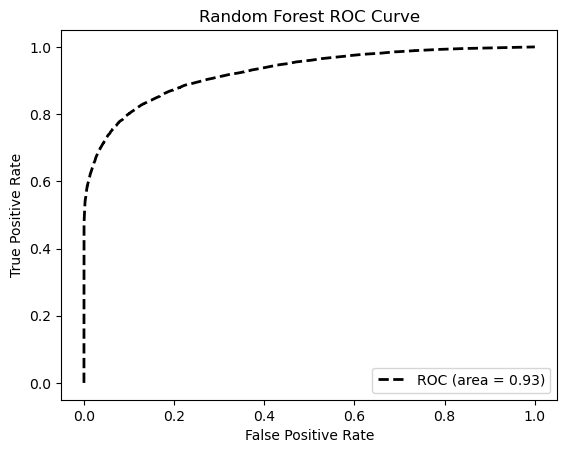

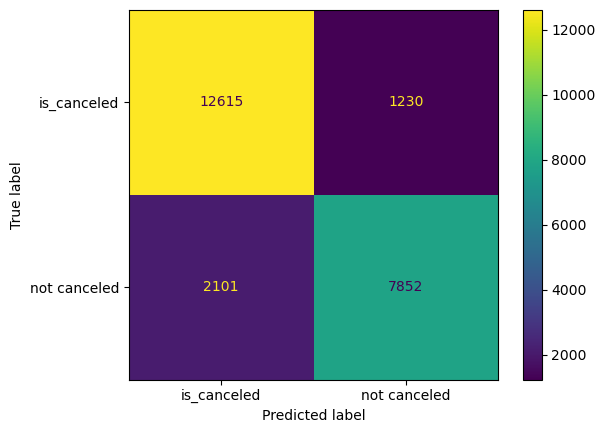

In [25]:
fpr, tpr, thersholds = roc_curve(y_test, list(rf_pre[:,1]))
 
# for i, value in enumerate(thersholds):
#     print("%f %f %f" % (fpr[i], tpr[i], value))
 
rf_auc = roc_auc_score(y_test,list(rf_pre[:,1]))
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(rf_auc), lw=2)
 
plt.xlim([-0.05, 1.05]) 
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
confusion_mat=confusion_matrix(y_test, random_forest.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['is_canceled','not canceled'])
disp.plot(
    include_values=True,            
    cmap="viridis",                 
    ax=None,                        
    xticks_rotation="horizontal",   
    values_format="d"               
)
plt.show()

In [26]:
results = {'0': ['Logistic Regression','KNN',"Decision Tree", 'Random Forest'],
          '1':[log_ac,knn_ac,dt_ac,rf_ac],
          '2':[log_auc,knn_auc,dt_auc,rf_auc]
          }
summary = pd.DataFrame.from_dict(results)
summary = summary.transpose()
summary = summary.rename(index = {'0':'model', '1':'accuracy','2':'auc'})
summary

,0,1,2,3
model,Logistic Regression,KNN,Decision Tree,Random Forest
accuracy,0.799605,0.773132,0.819355,0.86003
auc,0.849627,0.839988,0.817414,0.925363


# Prediction before feature selection

In [27]:
X_train_b, X_test_b=train_test_split(df_X, test_size=0.3, random_state=29)

In [28]:
#Logistic Regression
T1 = time.time()
logreg_b=LogisticRegression()
logreg_b.fit(X_train_b,y_train)
T2 = time.time()
log_ac_b = accuracy_score(y_test,logreg_b.predict(X_test_b))
log_pre_b=logreg_b.predict_proba(X_test_b)
log_auc_b= roc_auc_score(y_test,list(log_pre_b[:,1]))
time_log_b=(T2 - T1)*1000
# print("accuracy:%f"%log_ac)
# log_cv = cross_val_score(logreg, X_train, y_train, cv=10)
# log_cv_score = log_cv.mean()

In [29]:
#KNN
T1 = time.time()
knn_b=KNeighborsClassifier()
knn_b.fit(X_train_b,y_train)
T2 = time.time()
knn_ac_b = accuracy_score(y_test,knn_b.predict(X_test_b))
knn_pre_b=knn_b.predict_proba(X_test_b)
knn_auc_b = roc_auc_score(y_test,list(knn_pre_b[:,1]))
time_knn_b=(T2 - T1)*1000

In [30]:
#Decision Tree
T1 = time.time()
decision_tree_b = DecisionTreeClassifier() 
decision_tree_b.fit(X_train_b, y_train)
T2 = time.time()
dt_pre_b=decision_tree_b.predict_proba(X_test_b)
dt_ac_b = accuracy_score(y_test,decision_tree_b.predict(X_test_b))
dt_auc_b = roc_auc_score(y_test,list(dt_pre_b[:,1]))
time_dt_b=(T2 - T1)*1000
# print("accuracy:%f"%dt_ac)
# dt_cv = cross_val_score(decision_tree, X_train, y_train, cv=10)
# dt_cv_score = dt_cv.mean()

In [31]:
#Random Forest
T1 = time.time()
random_forest_b = RandomForestClassifier(n_estimators=100)
random_forest_b.fit(X_train_b,y_train)
T2 = time.time()
rf_ac_b = accuracy_score(y_test,random_forest_b.predict(X_test_b))
rf_pre_b=random_forest_b.predict_proba(X_test_b)
rf_auc_b = roc_auc_score(y_test,list(rf_pre_b[:,1]))
time_rf_b=(T2 - T1)*1000
# print("accuracy:%f"%rf_ac)
# rf_cv = cross_val_score(random_forest, X_train, y_train, cv=10)
# rf_cv_score = rf_cv.mean()

# Summary(before selection)

In [32]:
results = {'0': ['Logistic Regression','KNN',"Decision Tree", 'Random Forest'],
          '1':[log_ac_b,knn_ac_b,dt_ac_b,rf_ac_b],
          '2':[log_auc_b,knn_auc_b,dt_auc_b,rf_auc_b],
          '3':[time_log_b,time_knn_b,time_dt_b,time_rf_b]
          }
summary = pd.DataFrame.from_dict(results)
summary = summary.transpose()
summary = summary.rename(index = {'0':'model', '1':'accuracy','2':'auc','3':'time used/ms'})
summary

,0,1,2,3
model,Logistic Regression,KNN,Decision Tree,Random Forest
accuracy,0.77309,0.771325,0.832801,0.874569
auc,0.82169,0.839591,0.83122,0.939159
time used/ms,1076.140165,11.727095,313.621044,3790.485859


# Summary(after selection)

In [33]:
results = {'0': ['Logistic Regression','KNN',"Decision Tree", 'Random Forest'],
          '1':[log_ac,knn_ac,dt_ac,rf_ac],
          '2':[log_auc,knn_auc,dt_auc,rf_auc],
          '3':[time_log,time_knn,time_dt,time_rf]
          }
summary = pd.DataFrame.from_dict(results)
summary = summary.transpose()
summary = summary.rename(index = {'0':'model', '1':'accuracy','2':'auc','3':'time used/ms'})
summary

,0,1,2,3
model,Logistic Regression,KNN,Decision Tree,Random Forest
accuracy,0.799605,0.773132,0.819355,0.86003
auc,0.849627,0.839988,0.817414,0.925363
time used/ms,521.784782,34.453154,140.698195,3155.097008
